# Tutorial 4: RiboNN Translation Efficiency Prediction with Encodon

This notebook demonstrates predicting translation efficiency using pretrained Encodon models.

## Overview
- **Task**: Predict translation efficiency from mRNA sequences
- **Dataset**: RiboNN dataset with human translation efficiency data
- **Model**: Pretrained Encodon + Random Forest regressor
- **Method**: EncodonInference wrapper for embedding extraction

## 1. Import Libraries and Setup

In [2]:
import os
import sys
import warnings
from pathlib import Path

import numpy as np
import polars as pl
import torch
from tqdm import tqdm


warnings.filterwarnings("ignore")

# ML libraries
# Visualization
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split


# Add project paths
sys.path.append("..")

# Import Encodon modules
from src.data.metadata import MetadataFields
from src.inference.encodon import EncodonInference
from src.inference.task_types import TaskTypes


# Fix random seed
torch.manual_seed(42)
np.random.seed(42)

print("✅ Libraries imported successfully!")
print(f"PyTorch: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

✅ Libraries imported successfully!
PyTorch: 2.8.0a0+34c6371d24.nv25.08
CUDA available: True


## 2. Load Pretrained Encodon Model

In [ ]:
from src.utils.load_checkpoint import download_checkpoint


# download models if necessary
download_checkpoint(
    repo_id="nvidia/NV-CodonFM-Encodon-TE-80M-v1", local_dir="/data/checkpoints/NV-CodonFM-Encodon-TE-80M-v1"
)
download_checkpoint(
    repo_id="nvidia/NV-CodonFM-Encodon-TE-600M-v1", local_dir="/data/checkpoints/NV-CodonFM-Encodon-TE-600M-v1"
)
download_checkpoint(
    repo_id="nvidia/NV-CodonFM-Encodon-TE-1B-v1", local_dir="/data/checkpoints/NV-CodonFM-Encodon-TE-1B-v1"
)

In [ ]:
# Define checkpoint paths
checkpoint_paths = [
    "/data/checkpoints/NV-CodonFM-Encodon-TE-80M-v1",
    "/data/checkpoints/NV-CodonFM-Encodon-TE-600M-v1",
    "/data/checkpoints/NV-CodonFM-Encodon-TE-Cdwt-1B-v1",
]

checkpoint_path = checkpoint_paths[0]
model_loaded = False
if os.path.exists(checkpoint_path):
    try:
        device = "cuda" if torch.cuda.is_available() else "cpu"

        # Create EncodonInference wrapper
        encodon_model = EncodonInference(
            model_path=checkpoint_path, task_type=TaskTypes.EMBEDDING_PREDICTION, use_transformer_engine=True
        )

        # Configure model
        encodon_model.configure_model()
        encodon_model.to(device)
        encodon_model.eval()

        print(f"✅ Model loaded from: {checkpoint_path}")
        print(f"Device: {device}")
        print(f"Parameters: {sum(p.numel() for p in encodon_model.model.parameters()):,}")

        model_loaded = True
    except Exception as e:
        print(f"Failed to load {checkpoint_path}: {e}")

if not model_loaded:
    print("❌ Could not load any model. Please check checkpoint paths.")

## 3. Load Dataset

In [12]:
import os
import urllib.request


# Configurable dataset path
data_path = "/data/validation/processed/data_with_human_TE_cellline_all_NA_plain.csv"

# Source URL for the TE dataset
te_dataset_url = "https://raw.githubusercontent.com/CenikLab/TE_classic_ML/refs/heads/main/data/data_with_human_TE_cellline_all_NA_plain.csv"

# Ensure parent directory exists
Path(os.path.dirname(data_path)).mkdir(parents=True, exist_ok=True)

# Download if missing
if not os.path.exists(data_path):
    print(f"Downloading TE dataset to {data_path} ...")
    urllib.request.urlretrieve(te_dataset_url, data_path)
    print("Download complete.")
else:
    print(f"Found existing dataset at {data_path}.")

Found existing dataset at /data/validation/processed/data_with_human_TE_cellline_all_NA_plain.csv.


In [13]:
data = pl.read_csv(data_path, separator="\t")
data = data.with_columns(
    [
        pl.struct(["utr5_size", "cds_size", "tx_sequence"])
        .map_elements(
            lambda row: row["tx_sequence"][row["utr5_size"] : row["utr5_size"] + row["cds_size"]], return_dtype=pl.Utf8
        )
        .alias("cds_sequence"),
        pl.struct(["utr5_size", "tx_sequence"])
        .map_elements(lambda row: row["tx_sequence"][: row["utr5_size"]], return_dtype=pl.Utf8)
        .alias("utr5_sequence"),
        pl.struct(["utr5_size", "cds_size", "tx_sequence"])
        .map_elements(lambda row: row["tx_sequence"][row["utr5_size"] + row["cds_size"] :], return_dtype=pl.Utf8)
        .alias("utr3_sequence"),
    ]
).with_row_index("id")
output_path = data_path[:-4] + ".processed.csv"
data.write_csv(output_path)

In [14]:
# Load RiboNN dataset
data_loaded = False
if os.path.exists(output_path):
    try:
        data = pl.read_csv(output_path)
        print(f"✅ Loaded {len(data)} sequences from: {output_path}")
        print(f"Shape: {data.shape}")
        print(f"Key columns: {[col for col in ['id', 'cds_sequence', 'mean_te', 'fold'] if col in data.columns]}")

        data_loaded = True
    except Exception as e:
        print(f"Failed to load {output_path}: {e}")

    # Show basic statistics
    te_stats = data.select(
        [
            pl.col("mean_te").mean().alias("mean"),
            pl.col("mean_te").std().alias("std"),
            pl.col("mean_te").min().alias("min"),
            pl.col("mean_te").max().alias("max"),
        ]
    )
    print("\nTranslation Efficiency stats:")
    print(f"  Mean: {te_stats['mean'][0]:.4f}")
    print(f"  Range: [{te_stats['min'][0]:.4f}, {te_stats['max'][0]:.4f}]")
    data_loaded = True

✅ Loaded 11153 sequences from: /data/validation/processed/data_with_human_TE_cellline_all_NA_plain.processed.csv
Shape: (11153, 106)
Key columns: ['id', 'cds_sequence', 'mean_te', 'fold']

Translation Efficiency stats:
  Mean: 0.2474
  Range: [-2.6395, 3.4892]


## 4. Data Preprocessing

In [15]:
demo_size = 500  # set to len(data) for full dataset
batch_size = 16

# Subsample data while maintaining split proportions using sklearn
if data_loaded and demo_size < len(data):
    print("=== SUBSAMPLING DATA ===")
    sample_fraction = demo_size / len(data)
    _, data = train_test_split(data, test_size=sample_fraction, stratify=data["fold"], random_state=42)
else:
    print(f"Using full dataset: {len(data) if data_loaded else 0} samples")

=== SUBSAMPLING DATA ===


In [16]:
demo_size = 500  # set to len(data) for full dataset
batch_size = 16
if data_loaded and model_loaded:
    print("=== DATA PREPROCESSING ===")
    data = data.to_pandas()
    sequences = data["cds_sequence"].tolist()
    targets = data["mean_te"].values
    # Use subset for demo
    sequences = sequences
    targets = targets

    print(f"Processing {demo_size} sequences (demo mode)")

    # Extract embeddings
    print("\nExtracting embeddings...")
    all_embeddings = []

    for i in tqdm(range(0, len(sequences), batch_size)):
        batch_seqs = sequences[i : i + batch_size]

        # Prepare batch
        batch_items = []
        for j, seq in enumerate(batch_seqs):
            seq = seq.upper().replace("U", "T")
            tokens = encodon_model.tokenizer.tokenize(seq)
            input_ids = encodon_model.tokenizer.convert_tokens_to_ids(tokens)

            # Truncate if needed
            if len(input_ids) > encodon_model.model.hparams.max_position_embeddings - 2:  # Leave room for CLS/SEP
                input_ids = input_ids[: encodon_model.model.hparams.max_position_embeddings - 2]

            # Add special tokens
            input_ids = [encodon_model.tokenizer.cls_token_id] + input_ids + [encodon_model.tokenizer.sep_token_id]
            attention_mask = [1] * len(input_ids)

            batch_items.append(
                {
                    MetadataFields.INPUT_IDS: input_ids,
                    MetadataFields.ATTENTION_MASK: attention_mask,
                }
            )

        # Pad batch
        max_len = encodon_model.model.hparams.max_position_embeddings

        padded_input_ids = []
        padded_attention_masks = []
        batch_ids = []

        for item in batch_items:
            input_ids = item[MetadataFields.INPUT_IDS]
            attention_mask = item[MetadataFields.ATTENTION_MASK]

            # Pad
            pad_len = max_len - len(input_ids)
            input_ids.extend([encodon_model.tokenizer.pad_token_id] * pad_len)
            attention_mask.extend([0] * pad_len)

            padded_input_ids.append(input_ids)
            padded_attention_masks.append(attention_mask)

        # Create batch tensor
        batch = {
            MetadataFields.INPUT_IDS: torch.tensor(padded_input_ids, dtype=torch.long).to(encodon_model.device),
            MetadataFields.ATTENTION_MASK: torch.tensor(padded_attention_masks, dtype=torch.long).to(
                encodon_model.device
            ),
        }

        # Extract embeddings
        output = encodon_model.extract_embeddings(batch)
        all_embeddings.append(output.embeddings)

    # Combine embeddings
    embeddings = np.vstack(all_embeddings)
    print(f"\n✅ Extracted embeddings: {embeddings.shape}")

else:
    print("❌ Skipping preprocessing - data or model not loaded")

=== DATA PREPROCESSING ===
Processing 500 sequences (demo mode)

Extracting embeddings...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:13<00:00,  2.38it/s]


✅ Extracted embeddings: (500, 1024)


## 5. Train Random Forest

In [17]:
if "embeddings" in locals() and "targets" in locals():
    print("=== TRAINING RANDOM FOREST ===")
    results = {"r2_scores": [], "pearson_scores": [], "mse_scores": []}
    folds = data["fold"].unique()
    for fold in folds:
        train_idx = data[data["fold"] != fold].index
        test_idx = data[data["fold"] == fold].index
        X_train, X_test = embeddings[train_idx], embeddings[test_idx]
        y_train, y_test = targets[train_idx], targets[test_idx]

        # Train Random Forest
        rf = RandomForestRegressor(n_estimators=500, max_depth=15, min_samples_split=2, random_state=42, n_jobs=-1)

        rf.fit(X_train, y_train)
        y_pred = rf.predict(X_test)

        # Calculate metrics
        r2 = r2_score(y_test, y_pred)
        pearson_r, _ = pearsonr(y_test, y_pred)
        mse = mean_squared_error(y_test, y_pred)

        results["r2_scores"].append(r2)
        results["pearson_scores"].append(pearson_r)
        results["mse_scores"].append(mse)

        print(f"Fold {fold}: R² = {r2:.4f}, r = {pearson_r:.4f}")

    # Summary statistics
    mean_r2 = np.mean(results["r2_scores"])
    mean_pearson = np.mean(results["pearson_scores"])
    mean_mse = np.mean(results["mse_scores"])

    print("\n=== CROSS-VALIDATION RESULTS ===")
    print(f"Mean R²: {mean_r2:.4f} ± {np.std(results['r2_scores']):.4f}")
    print(f"Mean Pearson r: {mean_pearson:.4f} ± {np.std(results['pearson_scores']):.4f}")
    print(f"Mean RMSE: {np.sqrt(mean_mse):.4f}")

    # Store final model trained on all data
    final_rf = RandomForestRegressor(n_estimators=1000, max_depth=5, random_state=42, n_jobs=-1)
    final_rf.fit(embeddings, targets)
    final_predictions = final_rf.predict(embeddings)

else:
    print("❌ Cannot train - missing embeddings or targets")

=== TRAINING RANDOM FOREST ===
Fold 0: R² = 0.1847, r = 0.5366
Fold 8: R² = 0.3132, r = 0.6646
Fold 5: R² = 0.3702, r = 0.7084
Fold 7: R² = 0.2903, r = 0.5745
Fold 1: R² = 0.3519, r = 0.6480
Fold 3: R² = 0.3723, r = 0.7051
Fold 9: R² = 0.2300, r = 0.5158
Fold 6: R² = 0.3742, r = 0.6456
Fold 4: R² = 0.3871, r = 0.6730
Fold 2: R² = 0.1689, r = 0.6124

=== CROSS-VALIDATION RESULTS ===
Mean R²: 0.3043 ± 0.0784
Mean Pearson r: 0.6284 ± 0.0637
Mean RMSE: 0.6061


## 6. Plot Results

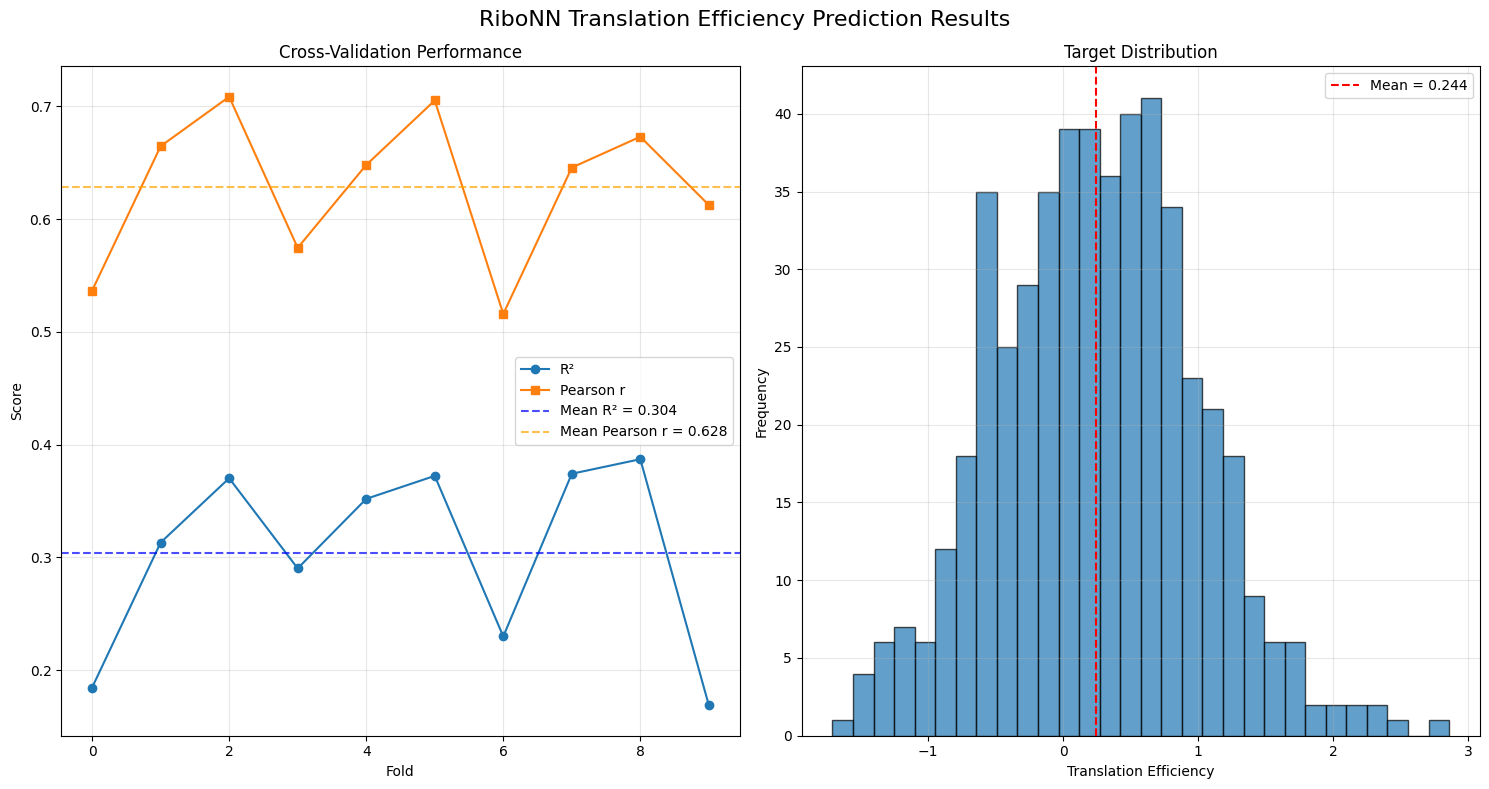

In [18]:
if "final_predictions" in locals():
    fig, axes = plt.subplots(1, 2, figsize=(15, 8))
    fig.suptitle("RiboNN Translation Efficiency Prediction Results", fontsize=16)

    # Cross-validation performance
    axes[0].plot(range(len(results["r2_scores"])), results["r2_scores"], "o-", label="R²")
    axes[0].plot(range(len(results["pearson_scores"])), results["pearson_scores"], "s-", label="Pearson r")
    axes[0].set_xlabel("Fold")
    axes[0].set_ylabel("Score")
    axes[0].set_title("Cross-Validation Performance")

    # Add mean performance lines
    mean_r2 = np.mean(results["r2_scores"])
    mean_pearson = np.mean(results["pearson_scores"])
    axes[0].axhline(mean_r2, color="blue", linestyle="--", alpha=0.7, label=f"Mean R² = {mean_r2:.3f}")
    axes[0].axhline(
        mean_pearson, color="orange", linestyle="--", alpha=0.7, label=f"Mean Pearson r = {mean_pearson:.3f}"
    )
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # Target distribution
    axes[1].hist(targets, bins=30, alpha=0.7, edgecolor="black")
    axes[1].axvline(targets.mean(), color="red", linestyle="--", label=f"Mean = {targets.mean():.3f}")
    axes[1].set_xlabel("Translation Efficiency")
    axes[1].set_ylabel("Frequency")
    axes[1].set_title("Target Distribution")
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()
else:
    print("❌ No results to plot")

## 7. Troubleshooting & Optimization Tips

### Common Issues and Solutions:

#### 1. Model Loading Issues
- **Problem**: Checkpoint not found
- **Solution**: Update checkpoint paths in section 2
- **Check**: Verify checkpoint files exist and are accessible

#### 2. Data Loading Issues
- **Problem**: Dataset not found
- **Solution**: Update data paths in section 3
- **Check**: Ensure CSV files have required columns (id, ref_seq, value)

#### 3. Memory Issues
- **Problem**: CUDA out of memory
- **Solution**: Reduce batch_size in preprocessing section
- **Alternative**: Use CPU by setting device='cpu'

#### 4. Performance Issues
- **Problem**: Low R² scores
- **Solutions**:
  - Try larger models (600M or 1B parameters)
  - Implement fine-tuning instead of just embeddings
  - Tune Random Forest hyperparameters
  - Check data quality and preprocessing


### Optimization Strategies:

#### 1. Model Architecture
- **80M model**: Fast, good for initial experiments
- **600M model**: Better performance, moderate cost
- **1B model**: Best performance, highest computational cost

#### 3. Hyperparameter Tuning
```python
# Try these Random Forest parameters:
rf_params = {
    'n_estimators': [100, 200, 500],
    'max_depth': [10, 15, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
```